In [1]:
import os
import torch
import tarfile
import torchvision
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url
from sklearn.model_selection import train_test_split
from pdf2image import convert_from_path
from shutil import copyfile
import shutil
import pandas as pd
import numpy as np
from collections import Counter
%matplotlib inline

### Script takes thee arguments:
   * path- the path to image we want to predict
   * model_path - the path to trained model
   * device - select the type of device for inference ('cpu' or 'cuda')

In [23]:
path = 'C:/Users/u10204/Desktop/OpenShift/infra/docker/c3p0/data/app/tmp/uploads/456.jpg'
model_path = 'resnet_50_all.pth'
device = torch.device('cpu')

### Classes for dataset creation

In [3]:
def get_train_transform():
    return transforms.Compose([
    
        transforms.Resize((224,224)), #becasue vgg takes 150*150
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.7137, 0.6974, 0.6911), (0.2814, 0.2879, 0.2976))

    ])

#Augmentation is not done for test/validation data.
def get_val_transform():
    return transforms.Compose([
    
    transforms.Resize((224,224)), #becasue vgg takes 150*150
    transforms.ToTensor(),
    transforms.Normalize((0.7137, 0.6974, 0.6911), (0.2814, 0.2879, 0.2976))
    
])

In [4]:
class Doc_Dataset(Dataset):
    
    def __init__(self, imgs,labels, class_to_int, mode = "train", transforms = None):
        
        super().__init__()
        self.imgs = imgs
        self.labels = labels
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image_name = self.imgs[idx]
        
        ### Reading, converting and normalizing image
        img = Image.open(image_name)
        img = img.convert('RGB')
        img = img.resize((224, 224))
        
        if self.mode == "train" or self.mode == "val":
        
            ### Preparing class label
            label = self.class_to_int[self.labels[idx]]
            label = torch.tensor(label, dtype = torch.long)
            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label
        
        elif self.mode == "test":
            
            ### Apply Transforms on image
            img = self.transforms(img)

            return img
            
        
    def __len__(self):
        return len(self.imgs)

### Classes for model and inference

In [5]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [6]:
class Doc_RESNET_model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = model_resnet50
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
# def get_default_device():
#     '''Pick GPU if available, else CPU'''
#     if torch.cuda.is_available():
#         return torch.device('cuda')
#     else:
#         return torch.device('cpu')

In [7]:
def to_device(data,device):
    '''move tensors to chosen device'''
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

In [8]:
def make_inference(input, model,device,inv_map):
    input = to_device(input,device)
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach().cpu()
    pred_label = np.argmax(prediction)
    pred_label = int(pred_label)
    pred_label = inv_map[pred_label]
    print(pred_label)
    return pred_label

In [ ]:
# device = get_default_device()
# print(device)

### Predict single image from path

In [12]:
model = torch.load(model_path, map_location={'cuda:0': 'cpu'})
model.eval()
model = to_device(model, device)

In [13]:
class_to_int = {"udo" : 0, "vid" : 1,'pass' : 2,'other':3}
inv_map = {v: k for k, v in class_to_int.items()}

In [24]:
# path = '/home/ocr/Pictures/CLASS_2_PASS/pass_31_1.jpg'
label = 'vid'
inf_image = [path]
inf_label = [label]

In [25]:
inference_dataset = Doc_Dataset(inf_image, inf_label,class_to_int, mode = "val", transforms = get_val_transform())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


other


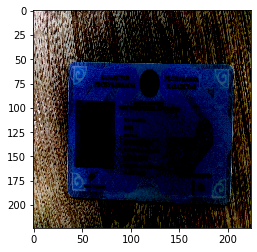

In [26]:
for i,img in enumerate(inference_dataset):
    plt.imshow(img[0].permute(1,2,0))
    answer = make_inference(img[0],model,device,inv_map)

In [28]:
answer

'other'

In [31]:
!pip freeze list

alabaster==0.7.12
albumentations==0.5.2
alembic==1.5.8
anaconda-client==1.7.2
anaconda-navigator==1.9.7
anaconda-project==0.8.3
APScheduler==3.7.0
asn1crypto==1.0.1
astroid==2.3.1
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.2.0
autowoe==1.2.4
Babel==2.7.0
backcall==0.1.0
backports.functools-lru-cache==1.5
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.8.0
bitarray==1.0.1
bkcharts==0.2
bleach==3.1.0
bokeh==1.3.4
boto==2.49.0
Bottleneck==1.2.1
Brotli==1.0.9
catboost==0.25.1
certifi==2019.9.11
cffi==1.12.3
chardet==3.0.4
Click==7.0
cliff==3.7.0
cloudpickle==1.2.2
clyent==1.2.2
cmaes==0.8.2
cmd2==1.5.0
colorama==0.4.1
colorlog==4.8.0
comtypes==1.1.7
conda==4.7.12
conda-build==3.18.9
conda-package-handling==1.6.0
conda-verify==3.4.2
contextlib2==0.6.0
convertdate==2.3.2
cryptography==2.7
cx-Oracle==7.3.0
cycler==0.10.0
Cython==0.29.21
cytoolz==0.10.0
dash==1.19.0
dash-core-components==1.15.0
dash-html-com